## Preparation

In [1]:
!pip install matplotlib

In [9]:
from gurobipy import *
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tsam.timeseriesaggregation as tsam
import july
from july.utils import date_range


## Load time series data

In [31]:
# Time series data of a whole year with hourly resolution
time_series_data =pd.read_csv('Data_Sheet.csv', sep=',', index_col=0)

print(time_series_data)


      s     t  dt  PowerD_demand  HeatD_demand  P_PV_tot  electricity_price
0     1     1   1          158.4     69.178754   0.00000          -0.013287
1     1     2   1          156.0     56.480866   0.00000          -0.002750
2     1     3   1          156.0     45.267146   0.00000          -0.003778
3     1     4   1          156.6     39.165564   0.00000          -0.013056
4     1     5   1          151.2     40.567279   0.00000          -0.011539
...  ..   ...  ..            ...           ...       ...                ...
8755  1  8756   1          168.6     15.307163   4.33854           0.023130
8756  1  8757   1          174.0     14.920863   0.00000           0.020431
8757  1  8758   1          167.4     14.293124   0.00000           0.015420
8758  1  8759   1          166.8     23.033177   0.00000           0.027447
8759  1  8760   1          160.2     32.497543   0.00000           0.006271

[8760 rows x 7 columns]


In [32]:
# Spaltennamen der 2., 3. und 4. Spalte ermitteln
columns_to_drop = time_series_data.columns[[0, 1, 2]]

# Neue Variable mit den herausgefilterten Spalten
modified_time_series_data = time_series_data.drop(columns=columns_to_drop)

print(modified_time_series_data)

      PowerD_demand  HeatD_demand  P_PV_tot  electricity_price
0             158.4     69.178754   0.00000          -0.013287
1             156.0     56.480866   0.00000          -0.002750
2             156.0     45.267146   0.00000          -0.003778
3             156.6     39.165564   0.00000          -0.013056
4             151.2     40.567279   0.00000          -0.011539
...             ...           ...       ...                ...
8755          168.6     15.307163   4.33854           0.023130
8756          174.0     14.920863   0.00000           0.020431
8757          167.4     14.293124   0.00000           0.015420
8758          166.8     23.033177   0.00000           0.027447
8759          160.2     32.497543   0.00000           0.006271

[8760 rows x 4 columns]


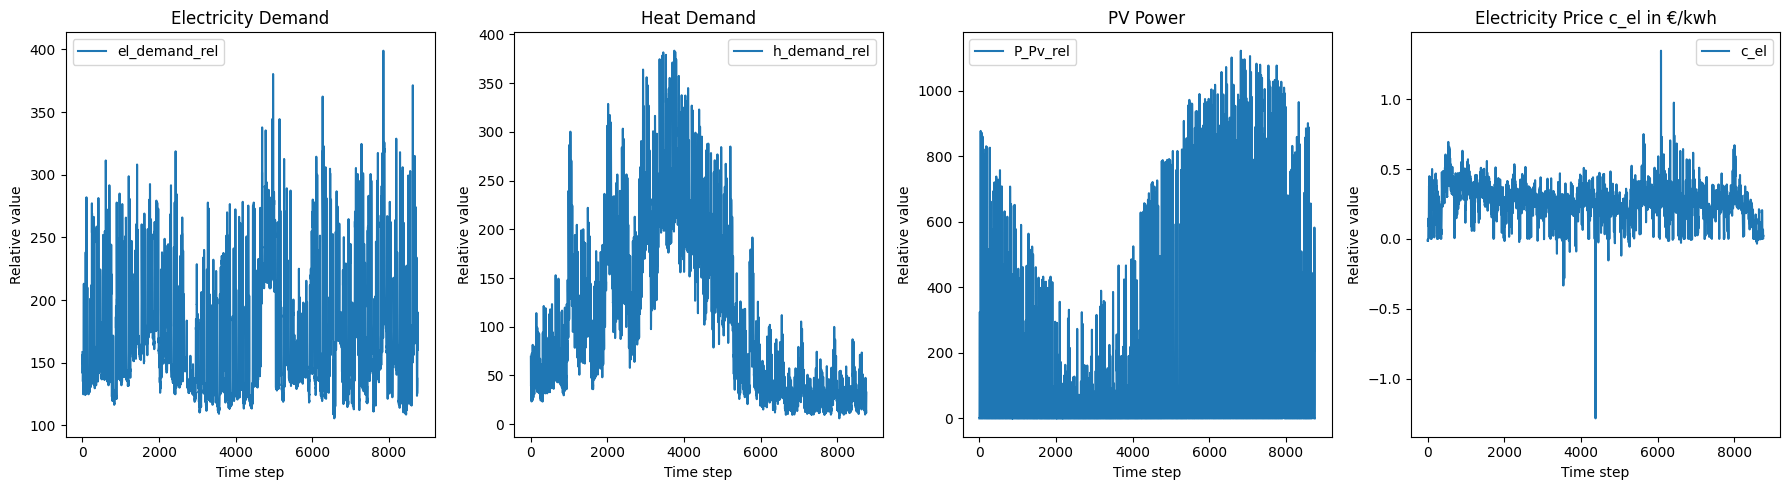

In [33]:
# Erstelle eine Figur mit 3 nebeneinanderliegenden Subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot für den ersten Datensatz
axes[0].plot(modified_time_series_data['PowerD_demand'], label='el_demand_rel')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Relative value')
axes[0].legend()
axes[0].set_title('Electricity Demand')

# Plot für den zweiten Datensatz
axes[1].plot(modified_time_series_data['HeatD_demand'], label='h_demand_rel')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Relative value')
axes[1].legend()
axes[1].set_title('Heat Demand')

# Plot für den dritten Datensatz
axes[2].plot(modified_time_series_data['P_PV_tot'], label='P_Pv_rel')
axes[2].set_xlabel('Time step')
axes[2].set_ylabel('Relative value')
axes[2].legend()
axes[2].set_title('PV Power')

# Plot für den dritten Datensatz
axes[3].plot(modified_time_series_data['electricity_price'], label='c_el')
axes[3].set_xlabel('Time step')
axes[3].set_ylabel('Relative value')
axes[3].legend()
axes[3].set_title('Electricity Price c_el in €/kwh')

# Layout anpassen
plt.tight_layout()

# Zeige die Plots
plt.show()


## Time series aggregation

In [39]:
# aggregate time_series_data with the tsam package
noTypicalPeriods = 4
hoursPerPeriod = 24

aggregation = tsam.TimeSeriesAggregation(
        timeSeries                  = modified_time_series_data,
        noTypicalPeriods            = noTypicalPeriods,
        hoursPerPeriod              = hoursPerPeriod,
        clusterMethod               = 'hierarchical',
        resolution                  = 1
    )
modified_time_series_data = aggregation.createTypicalPeriods()

print(modified_time_series_data)

            HeatD_demand  P_PV_tot  PowerD_demand  electricity_price
  TimeStep                                                          
0 0           182.102850  0.000000     141.020667           0.211352
  1           179.665142  0.000000     145.882327           0.209553
  2           172.003772  0.000000     143.104235           0.209959
  3           161.556449  0.000000     142.409713           0.212087
  4           157.377519  0.000000     141.715190           0.232738
...                  ...       ...            ...                ...
3 19           29.037418  4.113144     138.937098           0.398627
  20           27.041826  0.000000     133.380915           0.369589
  21           26.868297  0.000000     134.769961           0.340881
  22           37.106551  0.000000     138.242575           0.323752
  23           45.349214  0.000000     137.548052           0.296666

[96 rows x 4 columns]


In [ ]:
# Assign labels to each original period            #NEW
typical_days_row = aggregation.clusterOrder
print("Cluster Labels:")
print(typical_days_row)
print(len(typical_days_row))

In [36]:
# print the number of days represented by each typical day
for typical_day in np.arange(noTypicalPeriods):
    print(f"Typical day {typical_day} represents {aggregation.clusterPeriodNoOccur[typical_day]} days in the original time series")
    

Typical day 0 represents 92 days in the original time series
Typical day 1 represents 117 days in the original time series
Typical day 2 represents 100 days in the original time series
Typical day 3 represents 56 days in the original time series


    typical_day  TimeStep  HeatD_demand  P_PV_tot  PowerD_demand  \
0             0         0    182.102850       0.0     141.020667   
1             0         1    179.665142       0.0     145.882327   
2             0         2    172.003772       0.0     143.104235   
3             0         3    161.556449       0.0     142.409713   
4             0         4    157.377519       0.0     141.715190   
..          ...       ...           ...       ...            ...   
91            3        19    195.106276       0.0     129.213778   
92            3        20    195.694032       0.0     121.574026   
93            3        21    227.432872       0.0     124.352118   
94            3        22    269.163569       0.0     120.184980   
95            3        23    270.339081       0.0     118.101412   

    electricity_price  
0            0.211352  
1            0.209553  
2            0.209959  
3            0.212087  
4            0.232738  
..                ...  
91           0.

##für den langzeitstorrage die Zeitreihen erstellen

In [ ]:
days_yeahr=[i for i in range(1, 366)]  #NEW
print(days_yeahr)

In [ ]:
typical_days_dict = dict(zip(days_yeahr, typical_days_row))   #NEW
print(typical_days_dict)

In [ ]:
typical_hours_row =[] #

    
for i in range(1, 366):  #NEW
    #print(i)
    for j in range(24):
        typical_hours_row.append(typical_days_dict[i]*24+j)
        
print(len(typical_hours_row))
print(typical_hours_row)

In [ ]:
hours_to_typical_days= dict(zip(zahlenreihe,typical_hours_row))  #NEW
print(hours_to_typical_days)

In [ ]:
# reindex time series to have unique single-dimensional index starting from 0
modified_time_series_data = modified_time_series_data.reset_index()
modified_time_series_data = modified_time_series_data.rename(columns={'level_0': 'typical_day'})
modified_time_series_data.index = np.arange(0, noTypicalPeriods * hoursPerPeriod)
print(modified_time_series_data)

In [ ]:
modified_time_series_data.to_excel('modified_time_series_data.xlsx', index=False)
#!!in der exel  per Hand die TimeStep von 0 bis 95 durchlaufen lassen!!

## Setting up the time series for the optimization model:

In [ ]:
average_electricity_price = 70 # [€/MWh]
average_gas_price = 20 # [€/MWh]
average_heat_demand = 5 # [MW]

time_slices = np.array(time_series_data.index)

In [ ]:
shifted_time_slices = [] # time slice number shifted by 1 to create the storage level constraint
time_slice_weight = []

for typical_period in np.arange(noTypicalPeriods):
    time_slices_within_typical_period = time_series_data[time_series_data.typical_day == typical_period].index
    shifted_time_slices_within_period = np.roll(time_slices_within_typical_period,-1)
    shifted_time_slices.extend(shifted_time_slices_within_period) 
    time_slice_weight.extend(aggregation.clusterPeriodNoOccur[typical_period]*np.ones(len(time_slices_within_typical_period)))
    
print(shifted_time_slices)
print(time_slice_weight)

# weight of each time slice [h]
time_slice_weight = dict(zip(time_slices, time_slice_weight))

# consecutive time slice of each time slice
next_time_slice = dict(zip(time_slices, shifted_time_slices))

In [ ]:
# gas price of each time slice
gas_price_time_series = dict(zip(time_slices, np.array(time_series_data['gas']*average_gas_price)))

# electricity price of each time slice
electricity_price_time_series = dict(zip(time_slices, np.array(time_series_data['electricity']*average_electricity_price)))

# heat demand of each time slice
heat_demand_time_series = dict(zip(time_slices, np.array(time_series_data['heat_demand']*average_heat_demand)))


## Setting up the model:

In [ ]:
model = ConcreteModel()

# declare sets
model.time_slices = set(time_slices)

In [ ]:
# declare decision variables
model.CAPEX = Var(domain=NonNegativeReals) # [€]
model.OPEX = Var(domain=NonNegativeReals) # [€]
model.Q_N_B = Var(domain=NonNegativeReals) # [MW] installed capacity Boiler
model.Q_N_HP = Var(domain=NonNegativeReals) # [MW] installed capacity Heat Pump
model.Q_N_storage = Var(domain=NonNegativeReals) # [MWh] installed capacity of storage 

# declare time dependent decision variables
model.Q_B = Var(model.time_slices, domain=NonNegativeReals) # [MW]
model.Q_HP = Var(model.time_slices, domain=NonNegativeReals) # [MW]
model.Q_storage = Var(model.time_slices, domain=Reals) # [MW] [negative: storage charge, positive: storage discharge]
model.storage_level = Var(model.time_slices, domain=NonNegativeReals) # [MWh]

In [ ]:
# declare parameters
i = 0.05
lifetime = 30
model.RBF = ((1 + i) ** lifetime * i) / ((1 + i) ** lifetime - 1)

model.Q_max_B = 10 # [MW] maximal installable capacity of boiler
model.eta_B = 0.9
model.specific_invest_B = 2500 # [€/MW]

model.Q_max_HP = 10 # [MW] maximal installable capacity of heat pump
model.eta_HP = 3
model.specific_invest_HP = 100000 # [€/MW]

model.Q_max_storage = 40 # [MWh] maximal installable capacity of storage
model.storage_loss = 0.01 # [1/h] hourly storage loss
model.specific_invest_storage = 1000 # [€/MWh]

In [ ]:
# declare time dependent parameters
model.time_slice_weight = Param(model.time_slices, initialize = time_slice_weight)
model.gas_price = Param(model.time_slices, initialize = gas_price_time_series)
model.electricity_price = Param(model.time_slices, initialize = electricity_price_time_series)
model.Q_demand = Param(model.time_slices, initialize = heat_demand_time_series)

In [ ]:
# declare unindexed constraints
model.CAPEX_constraint = Constraint(expr =  model.CAPEX == model.RBF*(
                                        model.Q_N_B * model.specific_invest_B
                                        +  model.Q_N_HP * model.specific_invest_HP
                                        +  model.Q_N_storage * model.specific_invest_storage))

model.OPEX_constraint = Constraint(expr =  model.OPEX == sum(model.gas_price[time_slice] * model.Q_B[time_slice] / model.eta_B * model.time_slice_weight[time_slice] for time_slice in model.time_slices) 
                                   +  sum(model.electricity_price[time_slice] * model.Q_HP[time_slice] / model.eta_HP * model.time_slice_weight[time_slice] for time_slice in model.time_slices))

model.max_capacity_B_constraint = Constraint(expr = model.Q_N_B <= model.Q_max_B)
model.max_capacity_HP_constraint = Constraint(expr = model.Q_N_HP <= model.Q_max_HP)
model.max_capacity_storage_constraint = Constraint(expr = model.Q_N_storage <= model.Q_max_storage)


# declare rules to setup indexed constraints
def energy_balance_constraint_rule(model, time_slice):
    return model.Q_B[time_slice] + model.Q_HP[time_slice] + model.Q_storage[time_slice] == model.Q_demand[time_slice]

def max_Q_B_constraint_rule(model, time_slice):
    return model.Q_B[time_slice] <= model.Q_N_B

def max_Q_HP_constraint_rule(model, time_slice):
    return model.Q_HP[time_slice] <= model.Q_N_HP

def storage_level_constraint_rule(model, time_slice):
    return  (model.storage_level[next_time_slice[time_slice]] == (
        model.storage_level[time_slice] * (1-model.storage_loss)
        - model.Q_storage[time_slice])
    )
def storage_level_maximum_constraint_rule(model, time_slice):
    return  (model.storage_level[time_slice] <= model.Q_N_storage)

# declare indexed constraints
model.energy_balance_constraint = Constraint(model.time_slices, rule=energy_balance_constraint_rule)
model.max_Q_B_constraint = Constraint(model.time_slices, rule=max_Q_B_constraint_rule)
model.max_Q_HP_constraint = Constraint(model.time_slices, rule=max_Q_HP_constraint_rule)
model.storage_level_constraint = Constraint(model.time_slices, rule=storage_level_constraint_rule)
model.storage_level_maximum_constraint = Constraint(model.time_slices, rule=storage_level_maximum_constraint_rule)

In [ ]:
# declare objective
model.total_costs = Objective(expr = model.CAPEX + model.OPEX,
    sense = minimize)

## Solving the problem

In [ ]:
SolverFactory('gurobi').solve(model).write()

## Show the values of the objective and the variables:

In [ ]:
print(f"Total costs = {model.total_costs()} €")
print()
print(f"Q_N_B = {model.Q_N_B()} MW")
print(f"Q_N_HP = {model.Q_N_HP()} MW")
print(f"Q_N_storage = {model.Q_N_storage()} MWh")

In [ ]:
print(f"CAPEX = {model.CAPEX.value} €")
print(f"OPEX = {model.OPEX.value} €")